<img src="https://www.uss.cl/wp-content/themes/uss/img/logo.svg" width="200" height="200" style="float:left; padding:10px"/>

# Text Mining

Nicole Lastra Quiroz - Agosto 2022
----------

### Objetivo: 

Extraer y limpiar datos aplicando técnicas de preprocesamiento vistas en clases para  finalmente  construir una  visualización  (wordcloud)  delos  datos.Puede utilizar  redes  sociales,  o  cualquier  página  web  de  su  interés.  O  si  dispone  de datos como entrevistas o encuestas también pueden ser utilizadas.

### Instrucciones generales:
* Realizar web scrapping y trabajar con datos tabulares de páginas HTMLo utilizar una API para extraer datos.
* El archivo que debe entregar debe estar en lenguaje Python.
* Comente  su  código  por  secciones,  por ejemplo,si  tiene  una  función  que realiza  una  tarea  específica explique  que  hace  su  función,  lo  mismo  por bloques de instrucciones.

### Qué debe abordar en su proyecto:
1. Extracción de datos
2. Lectura de archivosy visualizar 5 líneas de estos.
3. Aplicar técnicas de preprocesamiento (expresión regular, stopwords, lemmatization, etc.) 
4. Crear un wordcloud para visualizar palabras más frecuentes.

## Desarrollo del proyecto

Se inicia el proyecto con la carga de librerías, sin olvidar el ignorar los warnings para efectos de limpieza del código.

In [245]:
# Carga de librerías
# ---------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import tweepy
import requests
import json

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nicolelastraquiroz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolelastraquiroz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nicolelastraquiroz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Se procede con la extracción de los datos con ayuda de la API de twitter y tweepy. 
Para esto, se debe de haber registrado una cuenta en twitter y solicitado los permisos necesarios en la sección de desarrollador, de modo que se tenga acceso al procesamiento de los datos.

In [246]:
# Definición de claves de acceso 
# ---------------------------------------------------------------------
consumer_key        = "xxxxxxxx"
consumer_secret     = "xxxxxxxx"
access_token        = "xxxxxxxx"
access_token_secret = "xxxxxxxx"
bearer_token        = "xxxxxxxx"

client = tweepy.Client( bearer_token, 
                        consumer_key, 
                        consumer_secret, 
                        access_token, 
                        access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit = True)


En este caso se decide trabajar con datos recolectados de los tweets de la cuenta oficial del Gobierno de Chile, los cuales serán guardados en un archivo csv para posterior procesado.

In [247]:
# Definición de la búsqueda a realizar
# ---------------------------------------------------------------------
query = 'from:GobiernodeChile -is:retweet'

# Obtención de tweets recientes con un máximo de 100 tweets
# ---------------------------------------------------------------------
tweets = client.search_recent_tweets(query       = query, 
                                     max_results = 100)

# guardado de la data como diccionario
# ---------------------------------------------------------------------
tweets_dict = tweets.json() 

# Extracción de "data" desde el diccionario
# ---------------------------------------------------------------------
tweets_data = tweets_dict['data'] 

# Transformación a DataFrame
# ---------------------------------------------------------------------
df = pd.json_normalize(tweets_data) 

# Información guardada como csv
# ---------------------------------------------------------------------
df.to_csv("gov.csv")

A continuación se puede ver la información extraída de los 5 primeros tweets y sus respectivos id.

In [248]:
# Visualización de las primeros 5 recopilaciones
# ---------------------------------------------------------------------
df.head(5)

,id,text
0,1558589968225865733,¿Eres de escuchar música o leer? 🎧🤔📖\nSi prefi...
1,1558569233163997202,¡No te quedes sin votar en el plebiscito del 4...
2,1558545173084360706,¡Tienes hasta el 21 de agosto! 🗓️ Tan solo deb...
3,1558500142092877827,Avanzamos en proyectos de economía circular♻️ ...
4,1558469802510925826,¿Revisaste? En 📲 https://t.co/e6bXgdVBYr ya es...


Se observa que existen emojis, páginas web, así como otros caracteres que deberán ser limpiados en la etapa de preprocesado para obtener un word cloud óptimo.

Se procede con una limpieza a los duplicados (pese a que como se configuró antes que no incluyera retweets difícilmente existirán duplicados), y una posterior creación de un objeto para realizar la lematización.

In [249]:
# Eliminación de duplicados y reset
# ---------------------------------------------------------------------
df       = df.drop_duplicates(keep = "first")
df_reidx = df.reset_index(drop = True)
df_reidx.shape

(33, 2)

In [250]:
# Creación de objeto para lemmatization
# ---------------------------------------------------------------------
lm = WordNetLemmatizer()

Ahora se procede con el preprocesado de la información, en donde se definirá el corpus y las restricciones de este, como la eliminación de las páginas web, el convertido a minúsculas de todas las palabras, la separación de las palabras como items, la eliminación de las stopwords, entre otros.

In [251]:
# Preprocesado de la información
# ---------------------------------------------------------------------

def text_transformation(df_col):
    corpus = []
    
    for item in df_col:
        
        # Eliminación de páginas web (palabras que empiezan por "http")
        # -------------------------------------------------------------
        new_item = re.sub('http\S+', ' ', str(item))
        
        #convertir a minuscula
        # -------------------------------------------------------------
        new_item = new_item.lower() 
        new_item = new_item.split() 
        
        # Eliminación de tokens con una longitud de 3 o menos letras
        # -------------------------------------------------------------
        new_item = [token for token in new_item if len(token) > 3]
        
        # Busqueda/eliminación de stopwords +lematizatizado de palabras
        # -------------------------------------------------------------
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('spanish'))]
        corpus.append(' '.join(str(x) for x in new_item))
        
   # Devolución de un corpus de los datos procesados
   # ------------------------------------------------------------------
    return corpus

Se aplica la función generada en el preprocessing al texto de los tweets y se guardan en el corpus.

In [252]:
# Aplicar función de preprocessing al texto + guardado en corpus
# ---------------------------------------------------------------------
corpus = text_transformation(df_reidx['text'])

Finalmente se procede con la creación del wordcloud en base al corpus generado.

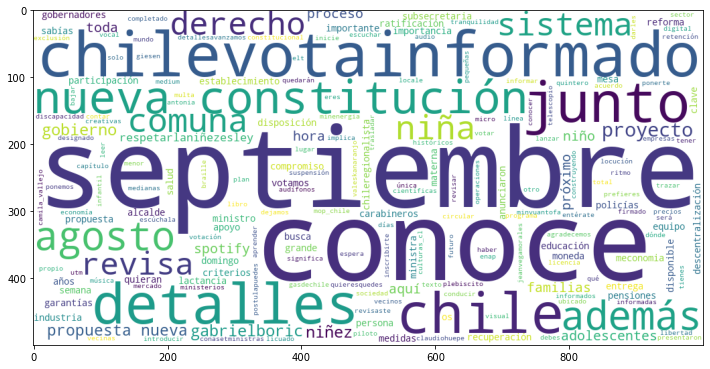

In [254]:
# Creación de wordcloud para ver las palabras más frecuentes
# ---------------------------------------------------------------------
plt.figure(figsize = (12, 8))

word_cloud = ""

for row in corpus:
    for word in row:
        word_cloud += " ".join(word)
        
wordcloud = WordCloud(width            = 1000, 
                      height           = 500,
                      background_color ='white',
                      min_font_size    = 10).generate(word_cloud)
plt.imshow(wordcloud)

### Conclusiones finales

En el wordcloud destacan palabras relativas al proceso constitucional que está viviendo Chile, lo que podría hablar de las inclinaciones que tiene el actual gobierno respecto a las pretenciones de resultados del plebiscito que se aproxima en septiembre, pero dado a que sólo se han considerado los últimos 31 tweets de la cuenta del gobierno, no es algo que se pueda afirmar, sin embargo, es evidente que en el wordcloud generado sí se destacan las mencionadas palabras, al margen de toda interpretación.

También llama la atención la presencia de las palabras "conoce" y "detalles", bastante destacadas en el wordcloud, ya que estas palabras suelen ser utilizadas en los tweets antecediendo a un sitio web, de forma "conoce más detalles en: ...", esto hace pensar sobre el filtrado y limpieza de los datos, ya que en futuros trabajos quizás se debería eliminar a estas palabras, de modo que no interfieran con el real significado de la información, al menos en términos de números.
